# Amber
## 0.0. PDB file 
The tutorial was written for Amber v.2024. 
Firstly we need to download the pdb file of the structure of interest (https://www.rcsb.org/)

In [94]:
!wget https://files.rcsb.org/view/1KX5.pdb

--2024-10-15 18:11:55--  https://files.rcsb.org/view/1KX5.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.157
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘1KX5.pdb’

1KX5.pdb                [     <=>            ]   1.39M  1.41MB/s    in 1.0s    

2024-10-15 18:11:57 (1.41 MB/s) - ‘1KX5.pdb’ saved [1457676]



We can make sure that the file is not empty by calling grep 

In [65]:
!grep '^ATOM' '1KX5.pdb'| head -n 10

ATOM      1  O5'  DA I -73      24.126 139.747  27.198  1.00 82.07           O  
ATOM      2  C5'  DA I -73      23.021 138.939  27.631  1.00 81.38           C  
ATOM      3  C4'  DA I -73      21.699 139.503  27.164  1.00 79.59           C  
ATOM      4  O4'  DA I -73      21.833 139.892  25.780  1.00 78.96           O  
ATOM      5  C3'  DA I -73      20.539 138.512  27.208  1.00 79.76           C  
ATOM      6  O3'  DA I -73      19.302 139.189  27.436  1.00 81.26           O  
ATOM      7  C2'  DA I -73      20.543 137.916  25.817  1.00 79.39           C  
ATOM      8  C1'  DA I -73      21.022 139.070  24.951  1.00 77.84           C  
ATOM      9  N9   DA I -73      21.853 138.618  23.840  1.00 75.36           N  
ATOM     10  C8   DA I -73      23.021 137.899  23.915  1.00 74.41           C  
grep: write error: Broken pipe


The structure can be visualised by nglview

In [84]:
#In presence with water
import nglview as nv
a=nv.show_structure_file('1KX5.pdb')
a.add_representation(selection='water',repr_type='spacefill',color='red')
a.render_image()
a

NGLWidget()

In [85]:
#Without water
import nglview as nv
a=nv.show_structure_file('1KX5.pdb')
a.render_image()
a

NGLWidget()

## 0.1. PDB File Preparation
Amber works with formated files, so in order to run molecular dynamics, especially the tleap part, it is necessary to modify them. Here we use MDAnalysis library, but you also can try pdb4amber command (See https://ambermd.org/tutorials/basic/tutorial9/index.php)

In [ ]:
#Rewrite each segid into different .pdb and merge them into modyfied sys.pdb 

import MDAnalysis as mda
!mkdir prep
!cd prep
pdb = mda.Universe('1KX5.pdb').select_atoms('protein or nucleic').write('prep/sys.pdb')

In [146]:
%%bash

cd prep/

grep '^ATOM' sys.pdb > sys_mod.pdb

## 1.0. Topology File Preparation
In order to start a MD simulation you should preapre a topolopgy file from .pdb. It can be obtained by LEaP programm; firstly an operator choses a force field model and defines it in LEaP, after the programm generates two necessary files: topolgy file and coordinates file. To learn more about a content of each extension read information below https://ambermd.org/tutorials/pengfei/index.php  
Structurally all leaprc. files are scripts: in case of ff14SB - the protein force field - tleap run also requiers supplemental information from .dat file, containing 'full' forcefield parameter information, and .ff14SB with an auxiliary parameter information, which is added when any conflict from .dat is obsereved. 

In [41]:
%%bash
module load amber24
dir $AMBERHOME/dat/leap/cmd/ #Here you can see a list of existing force fields
sed -n '80,84p' $AMBERHOME/dat/leap/cmd/leaprc.protein.ff14SB #parm10.dat is an example of parameter file

leaprc.amberdyes	 leaprc.protein.ff14SB_modAA
leaprc.conste		 leaprc.protein.ff14SBonlysc
leaprc.constph		 leaprc.protein.ff15ipq
leaprc.DNA.bsc1		 leaprc.protein.ff15ipq-vac
leaprc.DNA.OL15		 leaprc.protein.ff19ipq
leaprc.DNA.OL21		 leaprc.protein.ff19SB
leaprc.ffAM1		 leaprc.protein.ff19SB_modAA
leaprc.ffPM3		 leaprc.RNA.LJbb
leaprc.fluorine.ff15ipq  leaprc.RNA.OL3
leaprc.gaff		 leaprc.RNA.ROC
leaprc.gaff2		 leaprc.RNA.Shaw
leaprc.GLYCAM_06EPb	 leaprc.RNA.YIL
leaprc.GLYCAM_06j-1	 leaprc.water.fb3
leaprc.lipid21		 leaprc.water.fb3mod
leaprc.mimetic.ff15ipq	 leaprc.water.fb4
leaprc.modrna08		 leaprc.water.opc
leaprc.music		 leaprc.water.opc3
leaprc.phosaa10		 leaprc.water.opc3pol
leaprc.phosaa14SB	 leaprc.water.spce
leaprc.phosaa19SB	 leaprc.water.spceb
leaprc.phosfb18		 leaprc.water.tip3p
leaprc.protein.fb15	 leaprc.water.tip4pd
leaprc.protein.ff03.r1	 leaprc.water.tip4pd-a99SBdisp
leaprc.protein.ff03ua	 leaprc.water.tip4pew
leaprc.protein.ff12pol	 leaprc.xFPchromophores
leaprc.protei

Now we are ready to obtain required files! We will simulate the complex in opc water, using different force fields for DNA and proteins (bsc1, ff19SB, respectivelly). For this we will use leapt runner:

In [9]:
%%bash
module load amber24

tleap -h

-I: Adding /opt/amber24/dat/leap/prep to search path.
-I: Adding /opt/amber24/dat/leap/lib to search path.
-I: Adding /opt/amber24/dat/leap/parm to search path.
-I: Adding /opt/amber24/dat/leap/cmd to search path.
Usage: /opt/amber24/bin/teLeap [options]
Options:
 -h         Generate this message.
 -s         Ignore leaprc startup file.
 -I {dir}   Add {dir} to search path.
 -f {file}  Source {file}.


In [142]:
!cat scripts/creating_box/wo_ions.rc #the content of .rc script file

source leaprc.protein.ff19SB
source leaprc.DNA.bsc1
source leaprc.water.opc

mol = loadPDB prep/sys_mod.pdb
setBox mol vdw
solvateoct mol OPCBOX 10 iso 
addions mol K+ 0
addions mol Cl- 0
saveamberparm mol force_field/box_wo_kcl/draft_box.prmtop force_field/box_wo_kcl/draft_box.inpcrd
savepdb mol force_field/box_wo_kcl/draft_box.pdb
quit

Here the size of the box is regulated in solvateoct, ion aditions are written in addions section.
Now let's run force field without setting ion concentrations:

In [ ]:
%%bash

rm leap.log
mkdir force_field
cd force_field
mkdir box_wo_kcl
cd ..

module load amber24

tleap -s -f scripts/creating_box/wo_ions.rc # -s: programm will write a .log file; -f: file path

## 1.1. Topology file preparation: solvent parameters
However, to perform further energy minimisation it is necessary to create an electro-neutral solution, otherwise in pereodic boundary conditions (PBE) it will lead to infinitely big electrostatic interactions between the structure and other grid's boxes. Moreover it will perturbate solvent molecules near the cture and therefore will generate non-intuitive free energy changes. For better accordance with desired salt concentrarion SLTCAP method is used (DOI: 10.1021/acs.jctc.7b01254)

In [ ]:
%%bash

#Avogadro constant
n_a=6.022140857e+23 

# The density of water is ~0.997 g/mL at the room temperature, and thus, the weight of 1 L water is ~997 g.
# Since the weight of 1 mol H2O is ~18.02 g
# e.g. 1 L water is composed of ~3.33 × 10^25 H2O molecules (55.3 mol).
n_h20_in_one_liter=3.33E+25 

#Desired KCl concentration (mol/L)
n_kcl=0.15 

#The total number of water molecules
n_h20=$(grep '^  Added' leap.log | awk '{print $2}') 

#The number of solvent molecules in 1 L
n_kcl_in_one_liter=$(awk "BEGIN {print $n_kcl * $n_a; exit}") 

#The total number of solvent molecules
n0=$(awk "BEGIN {printf $n_kcl_in_one_liter / $n_h20_in_one_liter * $n_h20; exit}") 
n0=${n0%.*}

# The system's charge
q=$(grep -i "Total solute charge" leap.log | awk '{print $4}')

# final number of K+ and Cl- to neutralize system and to match the target salt concentration (SLTCAP)
n_k=$(echo "scale=10; $n0 * sqrt(1 + 1 / (2 * $n0)^2) - $q / 2" | bc)
n_cl=$(echo "scale=10; $n0 * sqrt(1 + 1 / (2 * $n0)^2) + $q / 2" | bc -l)
# rounding Numbers
n_k=$(printf '%1.0f' $n_k)
n_cl=$(printf '%1.0f' $n_cl)

echo $n_k, $n_cl #The number of K and Cl molecules

# Editing script

cp scripts/creating_box/wo_ions.rc scripts/creating_box/w_ions.rc

sed -i "s/addions mol K+ 0/addions mol K+ ${n_k}/g" scripts/creating_box/w_ions.rc
sed -i "s/addions mol Cl- 0/addions mol Cl- ${n_cl}/g" scripts/creating_box/w_ions.rc
sed -i "s/box_wo_kcl/box_kcl/g" scripts/creating_box/w_ions.rc
sed -i "s/draft_box/solvated_box/g" scripts/creating_box/w_ions.rc

# Starting simulation with new ion settings
cd force_field
mkdir box_kcl
cd ..
rm leap.log

module load amber24


tleap -s -f scripts/creating_box/w_ions.rc # -s: programm will write a .log file; -f: file path


## 2.0. Energy minimization and System Equillibration
To prevent formation of unusual high in energy structural patterns (e.g. close overlapse of Lennard-Jhonnes atomes) and stabilize the molecule, energy minimization should be performed. In Amber there are two minimization modules: sander and pmemd (see 21. sander in Amber2024) they both require special input file .in.

The full process includes 3 main steps*:
- Minimization
- Heating in a box with a constant value in a thermostat
- Relaxation (equillibration) at constnat temperature and constant pressure

Heating proccess depends on thermostat choice, which is defined in ntt variable in .in. Here we will be using ntt=1 - weak-coupling 
algorithm, it rescales total kinetic energy of the system, poured in a heat bath, to match the desired temperature. Note that this approach does not count local thermal changes. Weak-coupling here means that interaction between the structure and the hating bath is being ignored.

For big systems like nucleosomes it may be necessary to firstly restrain the molecule (Note the apex of min_1_draft.in and ntr value), although in this tutorial we will remove the restrain.

Let's have a look on .in and .sh files 

*Breefly (https://ambermd.org/tutorials/basic/tutorial14/index.php)

In [149]:
%%bash
cd scripts/min_eq
cat min_1_draft.in

Generated by amber_runner
&cntrl
    imin = 1
    maxcyc = 500
    ncyc = 250
    ntb = 1
    ntr = 1
    cut = 10.0
    ntpr = 1
/
DNA atoms
10.0
RES 975 1264
END
END


#imin=1, # single point energy calculation
#maxcyc=500, # maximum number of minimization cycles to allow. Default is 9999
#ncyc=250, # number of steepest descent method is used then conjugate gradient is switched on
#ntb=1, # constant volume
#ntr=1, # restraining specified atoms in Cartesian space using a harmonic potential
#cut=10.0, # non-bond cutoff radius
#ntpr=1 # md out print frequency


The .in file should be edited before run, i.e. restrains should be deleted 

In [150]:
%%bash
cat scripts/min_eq/min_1.in

Generated by amber_runner
&cntrl
    imin = 1
    maxcyc = 500
    ncyc = 250
    ntb = 1
    cut = 10.0
    ntpr = 1
/



#imin=1, # single point energy calculation
#maxcyc=500, # maximum number of minimization cycles to allow. Default is 9999
#ncyc=250, # number of steepest descent method is used then conjugate gradient is switched on
#ntb=1, # constant volume
#ntr=1, # restraining specified atoms in Cartesian space using a harmonic potential
#cut=10.0, # non-bond cutoff radius
#ntpr=1 # md out print frequency


In [114]:
%%bash

cat scripts/min_eq/newton_job_min_1.sh #the script for minimization, in your case it might be necessary to insert GPU, check __FILL__ .sh

#!/bin/bash -l

module load amber24

#export CUDA_VISIBLE_DEVICES=__FILL___

pmemd.cuda -O -i scripts/min_eq/min_1.in -o minimization/min_1/min_1.out -p force_field/box_kcl/solvated_box.prmtop -c force_field/box_kcl/solvated_box.inpcrd  -ref force_field/box_kcl/solvated_box.inpcrd -r minimization/min_1/min_1.ncrst -inf minimization/min_1/min_1.mdinfo
 
# -O - Overwrite output files
# -i   input file (md.in, which can be found above)
# -p   topology file (RAMP .prmtop)
# -c   the starting coordinate file (RAMP1_equil.rst7)
# -ref reference coordinates; use the same as the starting coordinates#
# -o   output file (RAMP1_md.out)
# -r   restart file (last set of xyz coordinates from the simulation)
# -x   file with trajectory (RAMP1_md.nc)

## 2.1. Initial minimization run 
Let's run the first minimization! 

In [ ]:
%%bash
#chmod +x scripts/min_eq/newton_job_min_1.sh
./scripts/min_eq/newton_job_min_1.sh

## 2.1. Minimization, Heating, and Equilibration
Let's have a look on a script, which allows us to run minimization and further heating and equilibration all at once, and run it

In [116]:
%%bash
cat scripts/min_eq/newton_job_min_eq.sh

#!/bin/bash -l

module load amber24

# export CUDA_VISIBLE_DEVICES=__FILL__

pmemd.cuda -O -i scripts/min_eq/min_2.in -o minimization/min_2/min_2.out -p force_field/box_kcl/solvated_box.prmtop -c force_field/box_kcl/solvated_box.inpcrd  -ref force_field/box_kcl/solvated_box.inpcrd -r minimization/min_2/min_2.ncrst -inf minimization/min_2/min_2.mdinfo
pmemd.cuda -O -i scripts/min_eq/heat.in -o minimization/heat/heat.out -p force_field/box_kcl/solvated_box.prmtop -c minimization/min_2/min_2.ncrst  -ref minimization/min_2/min_2.ncrst -r minimization/heat/heat.ncrst -x minimization/heat/heat.nc -inf minimization/heat/heat.mdinfo
pmemd.cuda -O -i scripts/min_eq/equil.in -o minimization/equil/equil.out -p force_field/box_kcl/solvated_box.prmtop -c minimization/heat/heat.ncrst -ref minimization/heat/heat.ncrst -r minimization/equil/equil.ncrst -x minimization/equil/equil.nc -inf minimization/equil/equil.mdinfo

# -O - Overwrite output files
# -i   input file (md.in, which can be found above)


In [ ]:
%%bash 
#chmod +x scripts/min_eq/newton_job_min_eq.sh
./scripts/min_eq/newton_job_min_eq.sh

## 2.2. Visualization
Let's visualizate the current progress and detect differences between three obtained structures. Firstly rewrite final coordinate file into new .pdb with a use of cpptraj.

*Note that output file does not contain information about molecule types (i.g. DNA or protein), that's why you should additionally edit it. See the second cell.

In [154]:
!cat scripts/trajectory_processing/pdb_converter.in
!module load amber24
!mkdir trajectory

#making .pdb files from .ncrst
for folder in ['min_2',
              'heat',
              'equil']:
    # !rm -rf trajectory/"$folder"
    !mkdir trajectory/"$folder"
    !cp scripts/trajectory_processing/pdb_converter.in scripts/trajectory_processing/"$folder".in
    !cp force_field/box_kcl/solvated_box.prmtop trajectory/"$folder"/"$folder".prmtop
    !sed -i "s#INITIAL_FILENAME#minimization/$folder/$folder#g" scripts/trajectory_processing/"$folder".in 
    !sed -i "s#OUTPUT#trajectory/$folder/$folder#g" scripts/trajectory_processing/"$folder".in 
    !cpptraj -i scripts/trajectory_processing/"$folder".in > scripts/trajectory_processing/cpptraj_"$folder".out 

parm force_field/box_kcl/solvated_box.prmtop
trajin INITIAL_FILENAME.ncrst
trajout INITIAL_FILENAME.pdb pdb
strip :WAT,K+,Na+,Cl- parmout OUTPUT.prmtop
autoimage
runmkdir: cannot create directory ‘trajectory’: File exists
mkdir: cannot create directory ‘trajectory/heat’: File exists
mkdir: cannot create directory ‘trajectory/equil’: File exists


In [155]:
import MDAnalysis as mda
import numpy as np 

#editing the output
for folder in ['min_2',
              'heat',
              'equil']:
    #!rm minimization/"$folder"/sys_"$folder".pdb
    !mdconvert minimization/"$folder"/"$folder".pdb -o minimization/"$folder"/sys_"$folder".pdb
    
    #note that segid's indexes A,B,C etc. are placed in an alphabet order and may differ from the initial placement
    
    u = mda.Universe(f'minimization/{folder}/sys_{folder}.pdb')
    
    #Rescaling of residues' indexes: you can see, that in initial .pdb similar residues have the same index
    for seg in u.segments:
        if seg.segid == 'A' or seg.segid == 'B':
            seg.residues.resids  = np.arange(-(len(seg.residues.resids)//2), len(seg.residues.resids)//2+1) #step ONLY for nucleosomes
        else:
            seg.residues.resids  = np.arange(1, len(seg.residues.resids)+1) #step for proteins or DNA

usage: mdconvert [-h] -o OUTPUT [-c CHUNK] [-f] [-s STRIDE] [-i INDEX]
                 [-a ATOM_INDICES] [-t TOPOLOGY]
                 input [input ...]
mdconvert: error: file exists: minimization/min_2/sys_min_2.pdb
converted 1 frames, 25086 atoms 
converted 1 frames, 25086 atoms 


In [156]:
import nglview as nv
min2=nv.show_structure_file('minimization/min_2/sys_min_2.pdb')
heat=nv.show_structure_file('minimization/heat/sys_heat.pdb')
equil=nv.show_structure_file('minimization/equil/sys_equil.pdb')
# a.add_representation(selection='water',repr_type='spacefill',color='red') #molecule in the box
min2.render_image()
heat.render_image()
equil.render_image()
min2

NGLWidget()

In [123]:
heat

NGLWidget()

In [124]:
equil 

NGLWidget()

## 3.0. Trajectory
Now let's process a trajectory to see the molecule moving!

In [157]:
# Create XTC from NC files 
## Create run file
!module load amber24

for folder in ['heat',
              'equil']: 
    !echo "parm force_field/box_kcl/solvated_box.prmtop" > trajectory/cpptraj_in.in
    !echo "trajin minimization/{folder}/{folder}.nc" >> trajectory/cpptraj_in.in
    !echo "trajout trajectory/{folder}/{folder}.nc" >> trajectory/cpptraj_in.in
    !echo "trajout trajectory/{folder}/{folder}.xtc" >> trajectory/cpptraj_in.in
    !echo "strip :WAT,K+,Na+,Cl- parmout trajectory/{folder}/{folder}.prmtop" >> trajectory/cpptraj_in.in
    !echo "autoimage" >> trajectory/cpptraj_in.in
    !echo "run" >> trajectory/cpptraj_in.in
    !cpptraj -i trajectory/cpptraj_in.in
 


CPPTRAJ: Trajectory Analysis. V18.00
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 12/07/24 10:33:59
| Available memory: 208.985 GB

INPUT: Reading input from 'trajectory/cpptraj_in.in'
  [parm force_field/box_kcl/solvated_box.prmtop]
	Reading 'force_field/box_kcl/solvated_box.prmtop' as Amber Topology
	Radius Set: modified Bondi radii (mbondi)
  [trajin minimization/heat/heat.nc]
	Reading 'minimization/heat/heat.nc' as Amber NetCDF
  [trajout trajectory/heat/heat.nc]
	Writing 'trajectory/heat/heat.nc' as Amber NetCDF
  [trajout trajectory/heat/heat.xtc]
	Writing 'trajectory/heat/heat.xtc' as Gromacs XTC
  [strip :WAT,K+,Na+,Cl- parmout trajectory/heat/heat.prmtop]
    STRIP: Stripping atoms in mask [:WAT,K+,Na+,Cl-]
	Stripped topology will be output with name 'trajectory/heat/heat.prmtop'
  [autoimage]
    AUTOIMAGE: To box center based on center of mass, anchor is first molecule.
  [run]
---------- RUN BEGIN --------------------------------------

In [167]:
import MDAnalysis as mda
import nglview as nv

#Note that starting .pdb file was obtained on a previous step

pdb = mda.Universe('minimization/min_2/sys_min_2.pdb', 'trajectory/heat/heat.xtc')
nv.show_mdanalysis(pdb)

NGLWidget(max_frame=199)

In [166]:
pdb = mda.Universe('minimization/heat/sys_heat.pdb', 'trajectory/equil/equil.xtc')
nv.show_mdanalysis(pdb)

NGLWidget(max_frame=19)

## 4.0 Energy
Let's obtain energy curves for heating and equilibration. Reminder: in .in script file for heating we 

In [ ]:
#Making an initial .in file for cpptraj

!module load amber24

for folder in ['heat',
              'equil']:
    !echo "parm trajectory/{folder}/{folder}.prmtop" > trajectory/cpptraj_in_energy_{folder}.in 
    !echo "reference minimization/{folder}/sys_{folder}.pdb" >> trajectory/cpptraj_in_energy_{folder}.in
    !echo "trajin trajectory/{folder}/{folder}.nc" >> trajectory/cpptraj_in_energy_{folder}.in
    !echo "energy out trajectory/ene_{folder}.txt" >> trajectory/cpptraj_in_energy_{folder}.in
    !cpptraj -i trajectory/cpptraj_in_energy_{folder}.in 

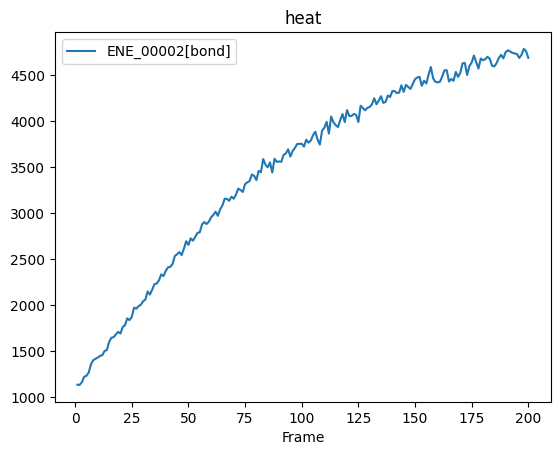

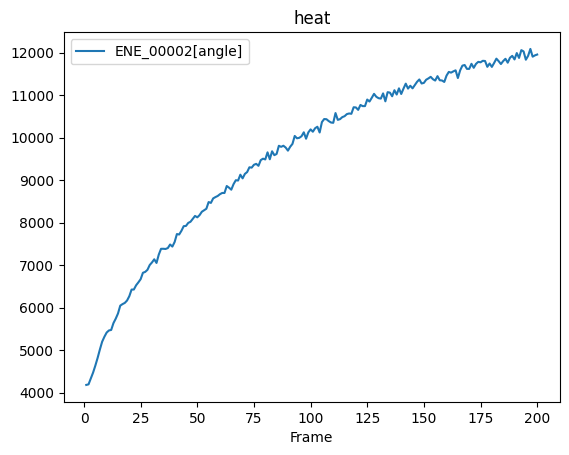

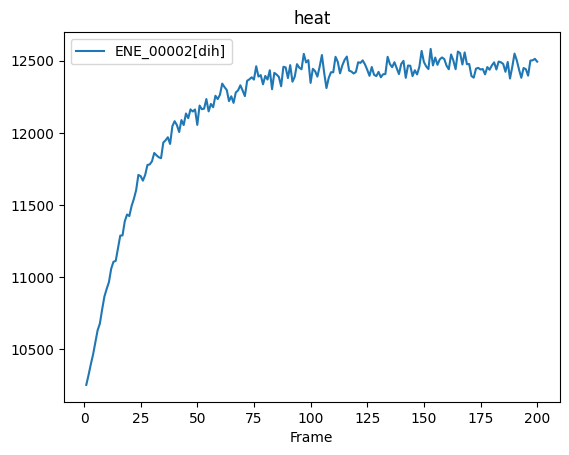

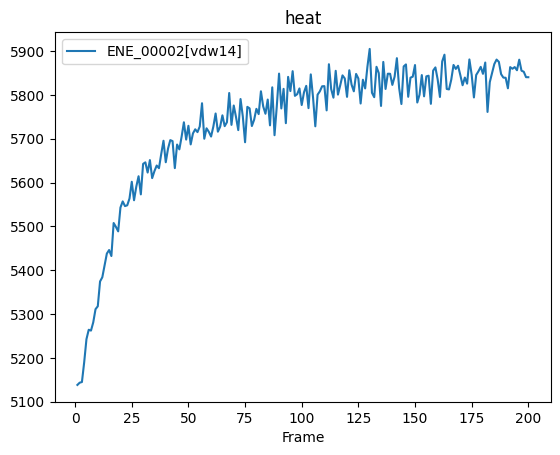

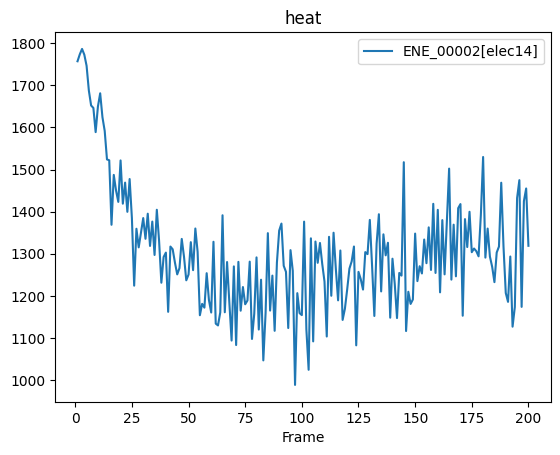

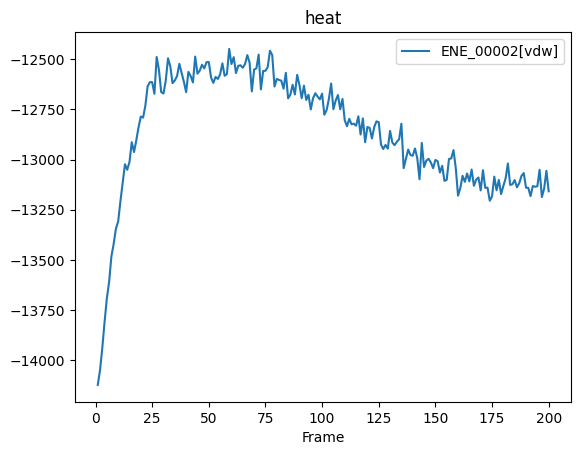

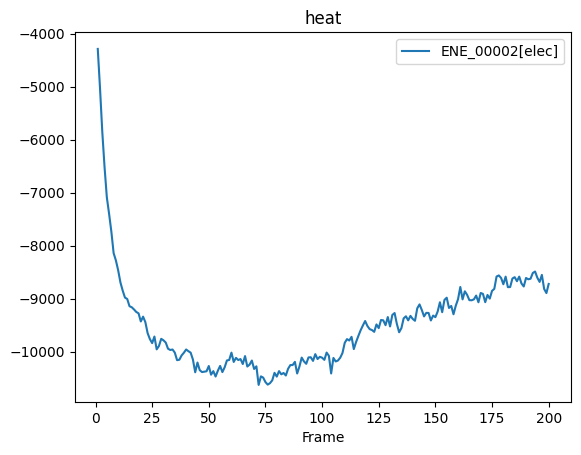

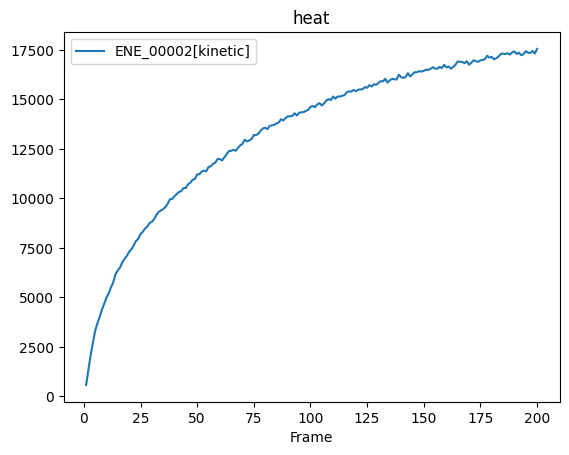

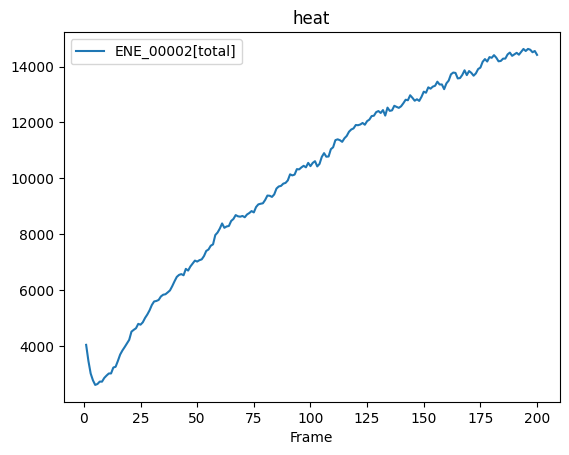

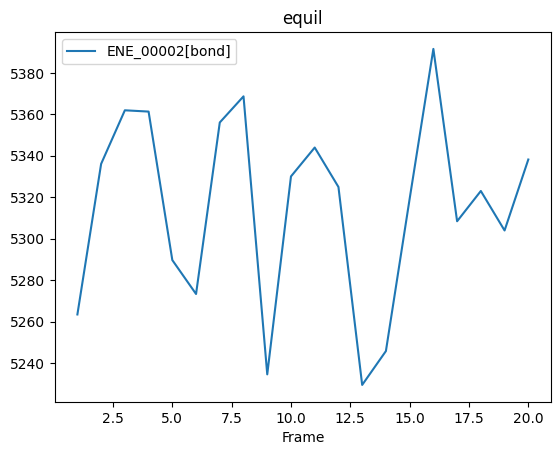

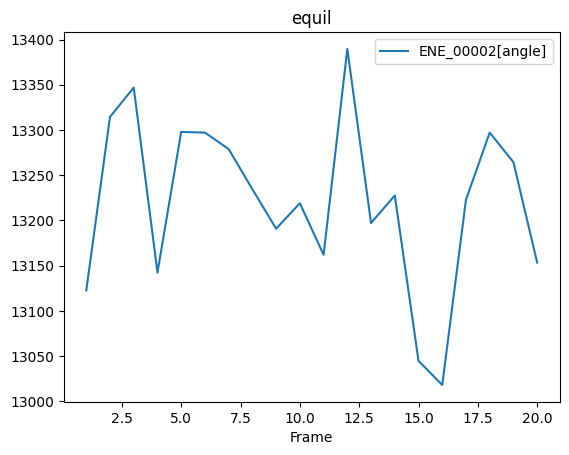

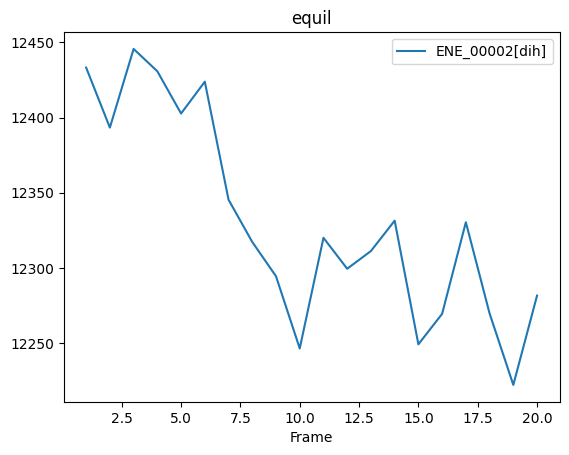

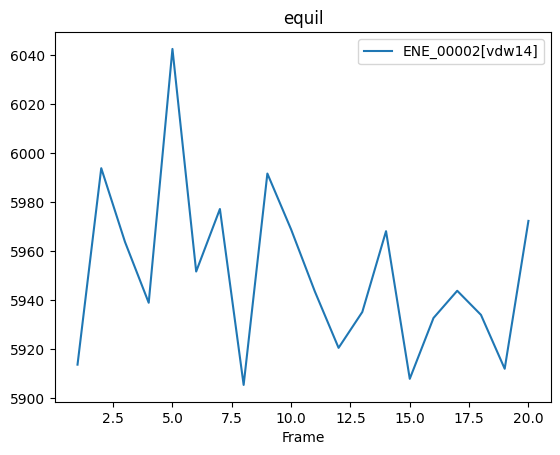

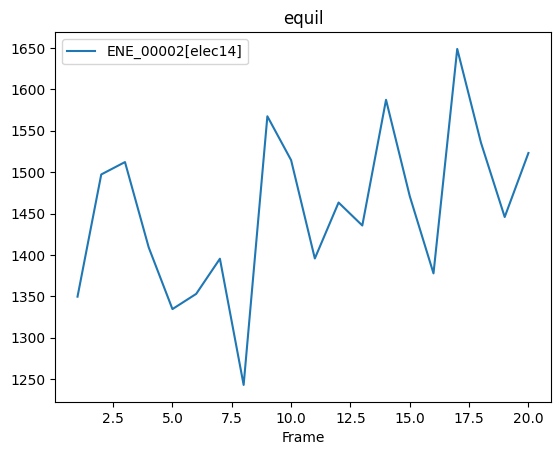

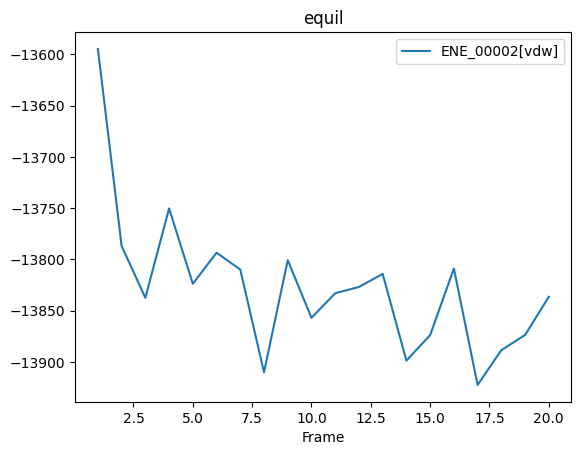

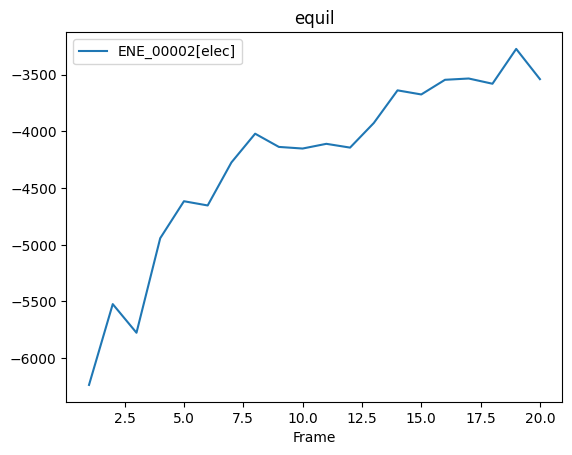

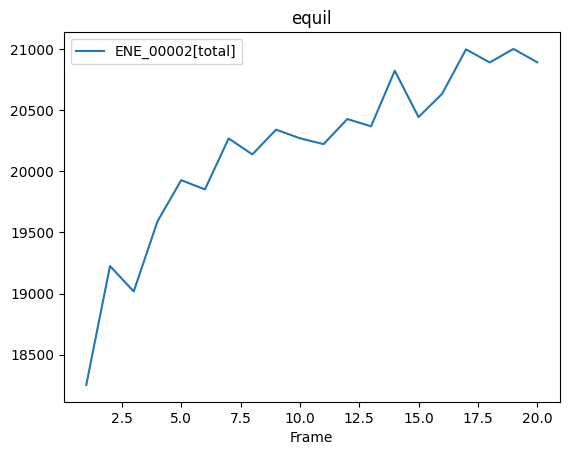

In [161]:
import pandas as pd 

#Visualisation of energy curves
#d = pd.DataFrame(np.loadtxt(f'trajectory/ene_equil.txt'), columns = 'Frame   ENE_00002[bond] ENE_00002[angle] ENE_00002[dih] ENE_00002[vdw14] ENE_00002[elec14] ENE_00002[vdw] ENE_00002[elec] ENE_00002[kinetic] ENE_00002[total]'.split())

d = pd.DataFrame(np.loadtxt(f'trajectory/ene_heat.txt'), columns = 'Frame   ENE_00002[bond] ENE_00002[angle] ENE_00002[dih] ENE_00002[vdw14] ENE_00002[elec14] ENE_00002[vdw] ENE_00002[elec] ENE_00002[kinetic] ENE_00002[total]'.split())
for c in 'ENE_00002[bond] ENE_00002[angle] ENE_00002[dih] ENE_00002[vdw14] ENE_00002[elec14] ENE_00002[vdw] ENE_00002[elec] ENE_00002[kinetic] ENE_00002[total]'.split():
    d.loc[:,['Frame',f'{c}']].plot(x = 'Frame', title = 'heat')
  


d = pd.DataFrame(np.loadtxt(f'trajectory/ene_equil.txt'), columns = 'Frame   ENE_00002[bond] ENE_00002[angle] ENE_00002[dih] ENE_00002[vdw14] ENE_00002[elec14] ENE_00002[vdw] ENE_00002[elec] ENE_00002[total]'.split())

for c in 'ENE_00002[bond] ENE_00002[angle] ENE_00002[dih] ENE_00002[vdw14] ENE_00002[elec14] ENE_00002[vdw] ENE_00002[elec] ENE_00002[total]'.split():
    d.loc[:,['Frame',f'{c}']].plot(x = 'Frame', title = 'equil')

## 5.0. Accuracy of MD
To confirm the accuracy of calculations, made previousely, several checks are required:
- Profiles of main MD parameters (temperature, pressure, energies)
- Distances between unit cells during simulation in order

MD parameters' data can be collected with process_mdout.perl command. It returns a full information about the system (.TEMP, .ETOT, .DENCITY, etc.)

Distances between images can be calculated with cpptraj module. Minimage calculates distances between selceted atoms/residues/molecules of two neigbouhring periodic images by default(https://amberhub.chpc.utah.edu/minimage/, https://amberhub.chpc.utah.edu/atom-mask-selection-syntax/). In this tutorial we will calculate distances only for equil.nc, in time-saving purposes.

### 5.1. process_mdout.perl

In [162]:
%%bash
#collecting outputs
module load amber24
rm -rf output
mkdir output
cd output

process_mdout.perl ../minimization/min_2/min_2.out ../minimization/heat/heat.out ../minimization/equil/equil.out

Processing sander output file (../minimization/min_2/min_2.out)...
Processing sander output file (../minimization/heat/heat.out)...
Processing sander output file (../minimization/equil/equil.out)...
Starting output...
Outputing summary.TEMP
Outputing summary_avg.TEMP
Outputing summary_rms.TEMP
Outputing summary.TSOLUTE
Outputing summary_avg.TSOLUTE
Outputing summary_rms.TSOLUTE
Outputing summary.TSOLVENT
Outputing summary_avg.TSOLVENT
Outputing summary_rms.TSOLVENT
Outputing summary.PRES
Outputing summary_avg.PRES
Outputing summary_rms.PRES
Outputing summary.EKCMT
Outputing summary_avg.EKCMT
Outputing summary_rms.EKCMT
Outputing summary.ETOT
Outputing summary_avg.ETOT
Outputing summary_rms.ETOT
Outputing summary.EKTOT
Outputing summary_avg.EKTOT
Outputing summary_rms.EKTOT
Outputing summary.EPTOT
Outputing summary_avg.EPTOT
Outputing summary_rms.EPTOT
Outputing summary.DENSITY
Outputing summary_avg.DENSITY
Outputing summary_rms.DENSITY
Outputing summary.VOLUME
Outputing summary_avg.VOL

Text(0, 0.5, 'Pressure (bar)')

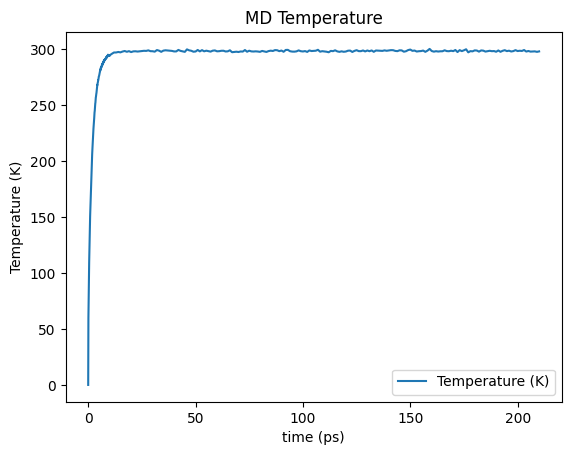

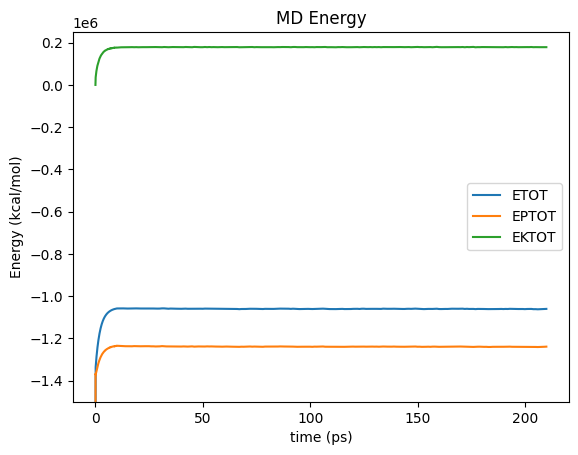

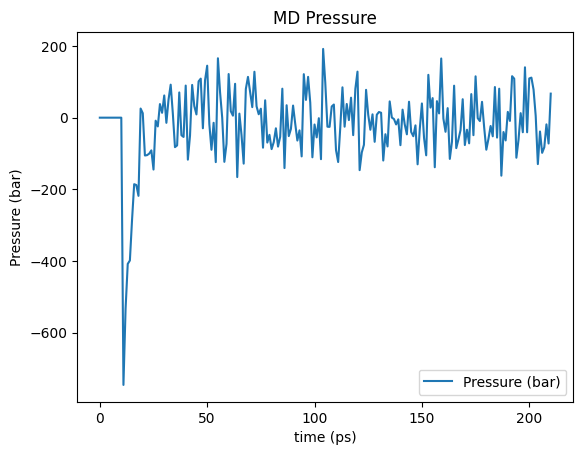

In [163]:
import numpy as np
import pandas as pd 

#Temperature Curve
d = pd.DataFrame(np.loadtxt('output/summary.TEMP'), columns = ['time (ps)', 'Temperature (K)'])
d.plot(x = 'time (ps)', y = 'Temperature (K)', title='MD Temperature').set_ylabel('Temperature (K)')

#Energy curves
d1 = pd.DataFrame(np.loadtxt('output/summary.ETOT'), columns = ['time (ps)', 'ETOT']) #Total Energy
d2 = pd.DataFrame(np.loadtxt('output/summary.EPTOT'), columns = ['time (ps)', 'EPTOT']) #Total Potintial Energy
d3 = pd.DataFrame(np.loadtxt('output/summary.EKTOT'), columns = ['time (ps)', 'EKTOT']) #Total Kinetic Energy
d1['EPTOT'] = d2['EPTOT']
d1['EKTOT'] = d3['EKTOT']
d1.plot(x = 'time (ps)', y = ['ETOT','EPTOT','EKTOT'], title='MD Energy', ylim=(-1500000, 250000)).set_ylabel('Energy (kcal/mol)')

#You can visualize each curve separatelly
# d1.plot(x = 'time (ps)', y = ['EKTOT'], title='MD Energy').set_ylabel('Energy (kcal/mol)')
# d1.plot(x = 'time (ps)', y = ['EPTOT'], title='MD Energy').set_ylabel('Energy (kcal/mol)')
# d1.plot(x = 'time (ps)', y = ['ETOT'], title='MD Energy').set_ylabel('Energy (kcal/mol)')

#Pressure Curve
d = pd.DataFrame(np.loadtxt('output/summary.PRES'), columns = ['time (ps)', 'Pressure (bar)'])
d.plot(x = 'time (ps)', y = 'Pressure (bar)', title='MD Pressure').set_ylabel('Pressure (bar)')


### 5.2. minimage
Note the 'autoimage' in .in file, it centeres trajectory with .promtop

In [138]:
!cat scripts/accuracy/minimage_script.in

parm force_field/box_kcl/solvated_box.prmtop
trajin minimization/equil/equil.nc
autoimage
minimage minimization/equil/equil.nc ^1-10 ^1-10 out output/output_min_distance.xvg 
run


In [ ]:
%%bash
module load amber24
cpptraj -i scripts/accuracy/minimage_script.in -o scripts/accuracy/minimage.out

Text(0, 0.5, 'Distance (A)')

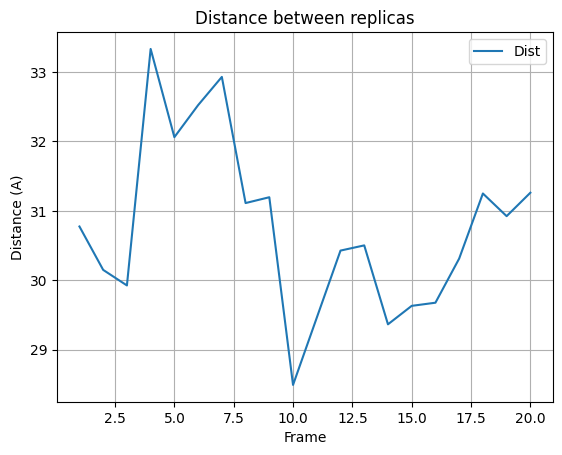

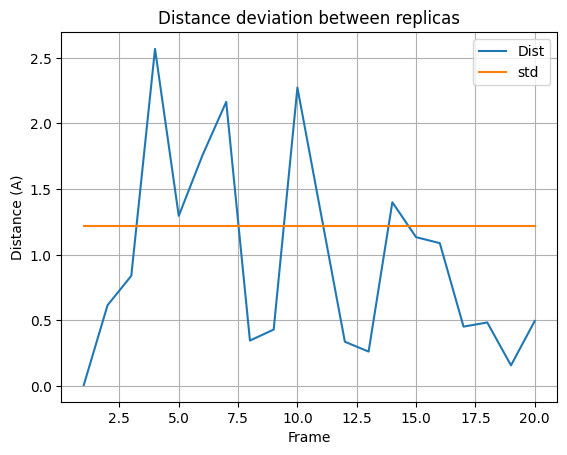

In [165]:
import numpy as np
import pandas as pd

#Distances between replicas
d = np.loadtxt('output/output_min_distance.xvg')
data = pd.DataFrame(d, columns = ['Frame', 'Dist', 'A1', 'A2'])
data.plot.line(x='Frame', y='Dist', title = 'Distance between replicas',grid=True).set_ylabel('Distance (A)')

#Distance deviations between replicas
mean = np.mean(d[:,1])
s = np.std(d[:,1])
for i in range(len(d)):
    d[i,1] = abs(d[i,1] - mean) 
data = pd.DataFrame(d, columns = ['Frame', 'Dist', 'A1', 'A2'])
data['std'] = s
data.plot.line(x='Frame', y=['Dist', 'std'], title = 'Distance deviation between replicas',grid=True).set_ylabel('Distance (A)')


### 0.0.0. Clear Your Workspace

In [144]:
!rm -rf prep
!rm scripts/creating_box/w_ions.rc
!rm leap.log
!rm -rf force_field
!rm -rf trajectory
!rm -rf output
for folder in ['min_1'
              'min_2',
              'heat',
              'equil']:
    !rm -rf minimization/"$folder"
    !mkdir minimization/"$folder""


rm: cannot remove 'scripts/creating_box/w_ions.rc': No such file or directory
rm: cannot remove 'trajectory/heat/.nfs00000000227c80160000089f': Device or resource busy
rm: cannot remove 'trajectory/heat/.nfs00000000227c803000000898': Device or resource busy
rm: cannot remove 'trajectory/equil/.nfs00000000227c8019000008a0': Device or resource busy
rm: cannot remove 'trajectory/equil/.nfs00000000227c802e00000899': Device or resource busy
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file
rm: cannot remove 'minimization/equil/.nfs000000001f8b001f000008a1': Device or resource busy
/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [104]:
!rm -rf minimization/min_1
!mkdir minimization/min_1